In [7]:
!pip install neuromancer

In [8]:
!pip install gymnasium

In [1]:
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.system import Node, System
from neuromancer.constraint import variable
from neuromancer.problem import Problem
from neuromancer.loss import PenaltyLoss
from neuromancer.trainer import Trainer
from neuromancer.loggers import MLFlowLogger
from neuromancer.psl.signals import signals

from neuromancer.dataset import DictDataset
from neuromancer.psl.plot import plot_pendulum_control
from neuromancer.psl.plot import plot_acrobot_control
from neuromancer.psl.plot import render_gymnasium
from neuromancer.psl.nonautonomous import GymnasiumPendulum, GymnasiumAcrobot
from neuromancer.psl.gymnasium_environments.gym_utils import wrap

import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

def discrete_random_walk(nsim, d=1, min=-1, max=+1, p=0.3, rng=np.random.default_rng()):
	U = np.zeros((nsim, d), dtype=np.float32)
	u = rng.choice([min, 0, max])
	for n in range(0, nsim):
		U[n, :] = u
		if rng.uniform()<p:
			u = rng.choice([min, 0, max])
	return U

signals['discrete'] = discrete_random_walk


# What Are We Learning
We are learning how to use Whitebox DPC to control either an Acrobot or Pendulum system.
In Whitebox DPC we interact directly with the original system, and in practice this is often infeasilbe as you have to know the differential equations that define the system prior to interaction.
For these two systems, we happen to know the equations that define the system.

![pendulum](https://gymnasium.farama.org/_images/pendulum.gif)  ![acrobot](https://gymnasium.farama.org/_images/acrobot.gif)

$$
\begin{align*}
\textbf{Pendulum System} \\
\dot{\theta} &= \omega \\
\ddot{\theta} &= \frac{3g}{2l} \sin(\theta) + \frac{3u}{ml^2} \\
\omega_{\text{new}} &= \omega + \left( \frac{3g}{2l} \sin(\theta) + \frac{3u}{ml^2} \right) \cdot \Delta t \\
\omega_{\text{new}} &= \text{clip}(\omega_{\text{new}}, -\omega_{\text{max}}, \omega_{\text{max}}) \\
\theta_{\text{new}} &= \theta + \omega_{\text{new}} \cdot \Delta t \\
\end{align*}

\begin{align*}
\textbf{Acrobot System} \\
d_1 &= m_1 \cdot lc_1^2 + m_2 \cdot (l_1^2 + lc_2^2 + 2 \cdot l_1 \cdot lc_2 \cdot \cos(\theta_2)) + I_1 + I_2 \\
d_2 &= m_2 \cdot (lc_2^2 + l_1 \cdot lc_2 \cdot \cos(\theta_2)) + I_2 \\
\phi_2 &= m_2 \cdot lc_2 \cdot g \cdot \cos(\theta_1 + \theta_2 - \frac{\pi}{2}) \\
\phi_1 &= -m_2 \cdot l_1 \cdot lc_2 \cdot \dot{\theta_2}^2 \cdot \sin(\theta_2) - 2 \cdot m_2 \cdot l_1 \cdot lc_2 \cdot \dot{\theta_2} \cdot \dot{\theta_1} \cdot \sin(\theta_2) \\
&\quad + (m_1 \cdot lc_1 + m_2 \cdot l_1) \cdot g \cdot \cos(\theta_1 - \frac{\pi}{2}) + \phi_2 \\
\ddot{\theta_2} &= \frac{a + \frac{d_2}{d_1} \phi_1 - m_2 \cdot l_1 \cdot lc_2 \cdot \dot{\theta_1}^2 \cdot \sin(\theta_2) - \phi_2}{m_2 \cdot lc_2^2 + I_2 - \frac{d_2^2}{d_1}} \\
\ddot{\theta_1} &= -\frac{d_2 \cdot \ddot{\theta_2} + \phi_1}{d_1}
\end{align*}
$$

If you want to learn more about the original systems you can reference the following documentation
| Pendulum | Acrobot |
| --- | --- |
| https://gymnasium.farama.org/environments/classic_control/pendulum/ | http://incompleteideas.net/papers/sutton-96.pdf |

# Deciding the Environment
At this point you can make a decision of which environment you want to learn a control policy for, you can make this choice by changing the `env_str` in the cell below.

In [2]:
env_str = "pendulum"
# env_str = "acrobot"

# Control
To build the controller for the Farama System, we are going to make sure that is going to produce control actions that are within the action bounds.
We can do this by using the Neuromancer `MLP_Bounds` class, which will apply a scaled and shifted sigmoid to our output dimension
and ensure that we only take valid actions.

In [3]:
envs = {
    "pendulum": GymnasiumPendulum,
    "acrobot": GymnasiumAcrobot
}
env = envs[env_str]()
policy = blocks.MLP_bounds(
    insize=env.ny,
    outsize=env.nu,
    hsizes=[128 for _ in range(2)],
    nonlin=activations['elu'],
    min=env.umin.item(),
    max=env.umax.item(),
)

## Interaction with True System

To interact with our true system, all that we have to do is wrap the `forward` call in a Neuromancer `Node` class.

In [4]:
policy_node = Node(policy, ["yn"], ["U"], name="policy")
system = Node(env.forward, ["yn", "U"], ["yn"], name="true system")

## Building the CL System
Now that we have all of the components, we just need to put them all together in a `System` class.

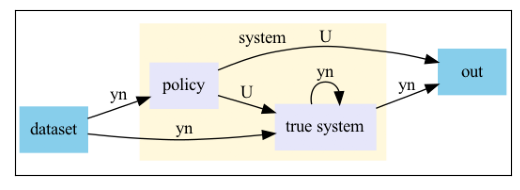

In [5]:
cl_system = System(
    [
        policy_node,
        system,
    ], nsteps=400, name="cl_system"
)
cl_system.show()

# Gathering the Initial Conditions
We need to gather some initial conditions to roll out the control problem for the Pendulum/Acrobot system.
For this all we need to do is call `get_x0()` on our Farama system which will sample initial conditions in a similar manner to the original system.

The reason that we need to sample many random initial conditions instead of just using the same one for all control sequences is due to the fact that DPC is a non-stochastic algorithm. This means that at a given training step, if we give it two identical initial conditions, it is going to roll out an identical sequence of control.

In [6]:
def get_initial_conditions(nsim: int, name: str):
    y0s = []
    for _ in range(nsim):
        x0 = env.get_x0()
        y0s.append(env.get_y0(x0=x0))
    y0s = torch.stack(y0s).reshape(nsim, 1, env.ny)
    dataset = DictDataset(
        {
            "yn": y0s,
        },
        name=name,
    )
    loader = torch.utils.data.DataLoader(
        dataset,
        collate_fn=dataset.collate_fn,
        batch_size=10_000, # Arbitrarily large batch size
        shuffle=True,
    )
    return loader

train_loader = get_initial_conditions(100, name="train")
dev_loader = get_initial_conditions(20, name="dev")


# Creating the Control Optimization Problem
It makes sense to try to replicate the reward of the orignal system defined by [The Farama Foundation](https://gymnasium.farama.org/environments/classic_control/pendulum/) as
$r = -(\theta^2 + 0.1 * \dot\theta^2+ 0.001 * u^2)$.
To cast this to a minimization problem we will define $\mathbb{\cal{L}}=-r$.

In [7]:
yn = variable("yn")[:, 1:, :]
u = variable("U")
losses = []

th = torch.atan2(yn[:, :, 1], yn[:, :, 0])
u = u[:, :, 0]
th = wrap(th, -torch.pi, torch.pi)
thdot = yn[:, :, 2]
costs = th ** 2 + 0.1 * thdot**2 + 0.001 * (u**2)
loss = (costs == 0)
losses.append(loss)

obj = PenaltyLoss(losses, [])
problem = Problem([cl_system], obj)

opt = optim.Adam(cl_system.parameters(), 0.001)

# Training the Controller

Now that we have defined the full closed loop interaction between the controller and the NSSM, we can hand it to the trainer to learn a control policy.

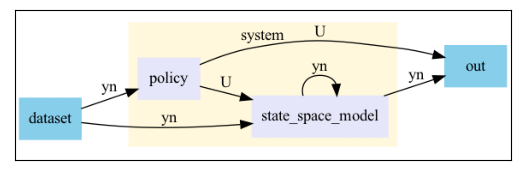

In [8]:
# If you want to skip the training proccess run this cell and skip the next

def load_controller(pkl_pth: str, state_dict_path: str, nsteps: int):
    import dill
    problem = torch.load(pkl_pth, pickle_module=dill, map_location=torch.device('cpu'))
    state_dict = torch.load(state_dict_path, map_location=torch.device('cpu'))
    problem.load_state_dict(state_dict)

    # Pull it out of the problem wrapper
    system = problem.nodes[0]

    # Get it ready for predictions
    system.nstep_key = "yn"
    system.nsteps = nsteps

    return system

system = load_controller(
    f"pretrained_weights/{env_str}_wb/{env_str}.pth",
    f"pretrained_weights/{env_str}_wb/{env_str}_state_dict.pth",
    400
)
best_model = system
best_model.show()

In [15]:
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer=opt,
    epochs=100_000,
    patience=200,
    train_metric="train_loss",
    eval_metric="dev_loss",
)
best_model = trainer.train()

trainer.model.load_state_dict(best_model)
best_model = problem.nodes[0]


epoch: 0  train_loss: 5.827780723571777
epoch: 1  train_loss: 8.316401481628418
epoch: 2  train_loss: 8.286507606506348
epoch: 3  train_loss: 7.269856929779053
epoch: 4  train_loss: 5.265660285949707
epoch: 5  train_loss: 6.452156066894531
epoch: 6  train_loss: 7.087389945983887
epoch: 7  train_loss: 7.453282833099365
epoch: 8  train_loss: 7.658255577087402
epoch: 9  train_loss: 7.7756123542785645
epoch: 10  train_loss: 7.861727237701416
epoch: 11  train_loss: 7.910026550292969
epoch: 12  train_loss: 7.947381973266602
epoch: 13  train_loss: 7.971743583679199
Interrupted training loop.


# Evaluation of the controller
It is very important to be able to see how your controller is performing visually with either plots or videos of control.
The nice thing about the Pendulum and Acrobot systems is that we can create gifs identical to the original Farama environment as we can simply backend to it for rendering.

loss=tensor([[633.6195]], grad_fn=<AddBackward0>)


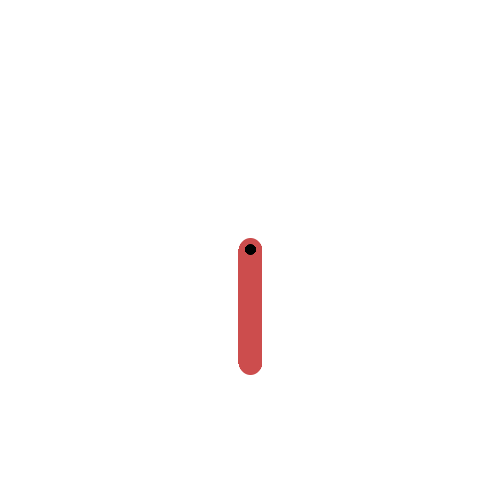

In [18]:
length = 400
test_set = env.get_y0(x0=env.x0) # Start in downright position
test_set = test_set.reshape(1, 1, env.ny)
test_set = {
    "yn": test_set,
}

pred = best_model(test_set)

frames = []
loss = 0.0
for i in range(length):
    x = env.y_to_x(pred["yn"][:, i, :])
    loss += env.get_loss(pred['yn'][:, i, :], pred["U"][:, i, :])
    frames.append(render_gymnasium(x=x.detach().numpy().squeeze(), render_mode="rgb_array", env_str=env.env_str))


optimal_state = env.optimal_state.repeat(length + 1, 1).reshape(1, length + 1, env.ny)
pred["optimal_state"] = optimal_state
pred["Zero"] = torch.zeros_like(pred["U"])

import imageio
fps = 10_000 # This should usually be 30, but jupyter needs it to be larger

imageio.mimsave(f'{env_str}_wb_control.gif', frames, duration=length/fps)
frames = np.array(frames)

from IPython.display import Image
print(f"{loss=}")
Image(open(f'{env_str}_wb_control.gif','rb').read())

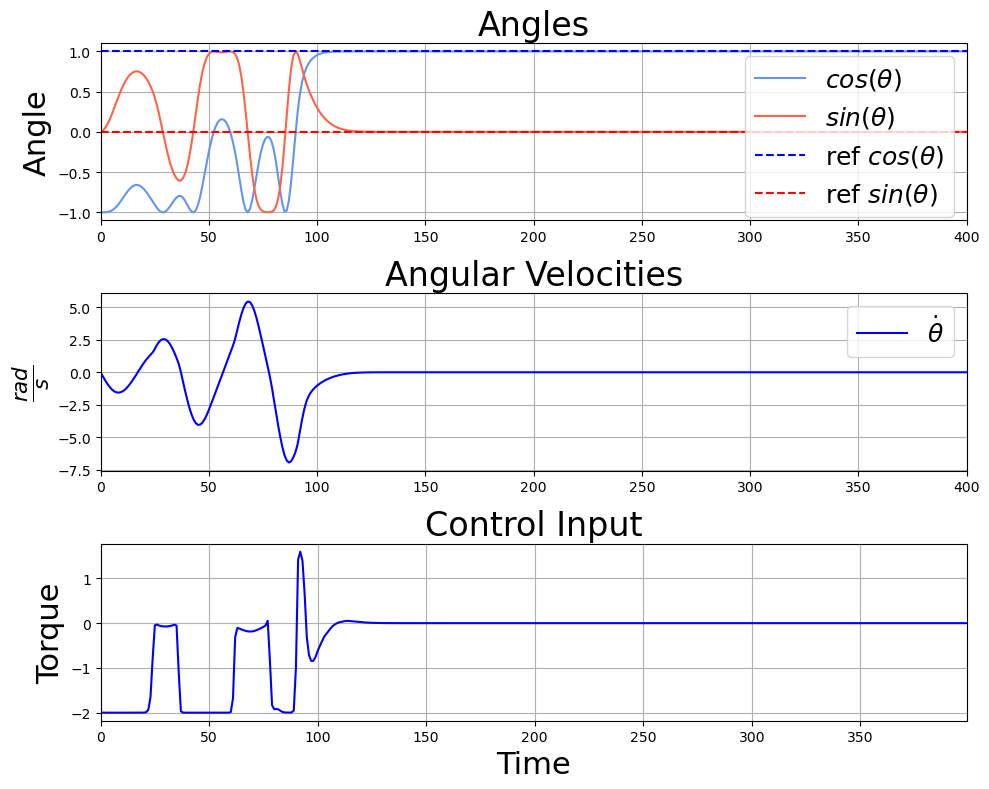

In [11]:
if env_str == "pendulum":
    plot_pendulum_control(pred)
else:
    plot_acrobot_control(pred)